 # Principal Component Analysis (PCA)
 
### Contexto

Dada una matriz $X_{pxn}$ de $n$ observaciones y $p$ dimensiones, PCA busca una matriz reducida $X'_{qxn}$ ($q<p$) que capture la mayor variabilidad posible de la base de datos, es decir, que pierda la menor información posible. 

Para realizar dicha transformación debemos encontrar una matriz $A_{qxp}$ tal que, 

$A_{qxp}X_{pxn} = X'_{qxn}$

Como vimos en clases, esta matriz se compone de los $q$ vectores propios de la matriz de covarianza con mayores valores propios. 

Para ilustrar el algoritmo, utilizaremos el dataset [**winequality-red**](https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009), que tiene distintos atributos de distintos vinos rojos, además de la calidad de estos según expertos. Mediante PCA, buscaremos dos componentes principales, transformaremos los datos y los plotearemos en un scatter plot de dos dimensiones, para ver si hay algún patrón entre los atributos de un vino y su calidad. 

# Descargar dataset

A continuación se deja un código capaz de descargar cualquier archivo de google drive mientras dicho archivo sea público.

In [1]:
from requests import Session

def download_file_without_authenticate(id, destination):
    def get_confirm_token(response):
        for key, value in response.cookies.items():
            if key.startswith("download_warning"):
                return value

    URL = "https://docs.google.com/uc?export=download"
    session = Session()
    response = session.get(URL, params={"id": id}, stream=True)
    token = get_confirm_token(response)

    if token:
        params = {"id": id, "confirm": token}
        response = session.get(URL, params=params, stream=True)

    CHUNK_SIZE = 32768
    with open(destination, "wb") as f:
        for i, chunk in enumerate(response.iter_content(CHUNK_SIZE)):
            if chunk:  # filter out keep-alive new chunks
                f.write(chunk)

    return None

download_file_without_authenticate("1FoK4OGN7gZS_XoE5Yx_CyUflQLO8vjvK", "winequality-red.csv")
!ls

README.md           main.ipynb          winequality-red.csv


## Importar las librerías necesarias

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable

## Importar archivo `winequality-red.csv` en un `DataFrame`

In [3]:
wines = pd.read_csv('winequality-red.csv')

## Describir dataset

Ver como vienen los datos: ¿Hay valores nulos?¿Qué columnas hay?¿Qué significa cada columna? (No es necesario que escribas estas respuestas, solo utiliza métodos descriptivos de los `DataFrames` para conocer el dataset)

In [11]:
# Buscamos valores nulos y notamos que no hay :D
wines[wines.isnull().any(axis=1)]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality


In [14]:
# Notamos que las columnas se refieren a las propiedades químicas de los vinos
print(wines.columns)
print(wines.describe())

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')
       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000       1599.000000  1599.000000     1599.000000   
mean        8.319637          0.527821     0.270976        2.538806   
std         1.741096          0.179060     0.194801        1.409928   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.200000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1599.000000          1599.000000           1599.0

## Preprocesar la base de datos

- Separa la base de datos en dos: una estructura con los atributos numéricos de los vinos y otra con la calidad de estos (columna `quality`). 
- Normaliza los datos. No es necesario normalizar la calidad en este caso. 

In [16]:
quality = wines['quality']
wine_data = wines.drop(['quality'], axis=1)
print(quality)
print(wine_data)

0       5
1       5
2       5
3       6
4       5
       ..
1594    5
1595    6
1596    6
1597    5
1598    6
Name: quality, Length: 1599, dtype: int64
      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0               7.4             0.700         0.00             1.9      0.076   
1               7.8             0.880         0.00             2.6      0.098   
2               7.8             0.760         0.04             2.3      0.092   
3              11.2             0.280         0.56             1.9      0.075   
4               7.4             0.700         0.00             1.9      0.076   
...             ...               ...          ...             ...        ...   
1594            6.2             0.600         0.08             2.0      0.090   
1595            5.9             0.550         0.10             2.2      0.062   
1596            6.3             0.510         0.13             2.3      0.076   
1597            5.9             0.645 

In [72]:
# Aplicamos la normalización a cada columna
wine_norm = wine_data.apply(lambda x: (x - x.min())/(x.max()-x.min()))
print(wine_norm)

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0          0.247788          0.397260         0.00        0.068493   0.106845   
1          0.283186          0.520548         0.00        0.116438   0.143573   
2          0.283186          0.438356         0.04        0.095890   0.133556   
3          0.584071          0.109589         0.56        0.068493   0.105175   
4          0.247788          0.397260         0.00        0.068493   0.106845   
...             ...               ...          ...             ...        ...   
1594       0.141593          0.328767         0.08        0.075342   0.130217   
1595       0.115044          0.294521         0.10        0.089041   0.083472   
1596       0.150442          0.267123         0.13        0.095890   0.106845   
1597       0.115044          0.359589         0.12        0.075342   0.105175   
1598       0.123894          0.130137         0.47        0.184932   0.091820   

      free sulfur dioxide  total 

# PCA

### 1. Obtener la matriz de covarianzas de los datos y los valores y vectores propios asociados


In [76]:
# Se obtiene la matriz de covarianza y los valores y vectores propios
cov = wine_norm.cov()
val_propios, vect_propios = np.linalg.eig(cov)

# Se guardan en un diccionario
eigenv = {}
eigenv.update(zip(val_propios, vect_propios))

### 2. Obtener los 2 vectores propios con los mayores valores propios

In [74]:
max_vals = np.sort(val_propios)
W = np.array([eigenv[max_vals[-1]], eigenv[max_vals[-2]]])
W

array([[ 0.51228717, -0.046458  ,  0.15212435, -0.57037196, -0.33518401,
        -0.14342515, -0.04032162,  0.11441858, -0.37604198,  0.29765084,
         0.09642298],
       [-0.22123978, -0.26457999,  0.18403287, -0.00337754, -0.44659459,
         0.32734852,  0.11114762,  0.37986516,  0.39026436,  0.10361279,
         0.46997222]])

### 3. Reducir la dimensionalidad de los datos originales
Si no te calzan las dimensiones, utiliza el método `shape` para revisarlas. 

In [81]:
print(f'Dimensión de W: {W.shape}')
print(f'Dimensión de X: {wine_norm.shape}')

reduced = np.dot(W, wine_norm.transpose()).transpose()
print(f'Dimensión de los datos transformados: {reduced.shape}')

Dimensión de W: (2, 11)
Dimensión de X: (1599, 11)
Dimensión de los datos transformados: (1599, 2)


## Visualizar los datos transformados

Utiliza `matplotlib` o alguna librería de visualización para ver los datos transformados en un scatter plot de dos dimensiones. Utiliza la estructura con las calidades que guardaste antes (de la columna `quality`) para diferenciar las distintas calidades de vinos, coloreando las calidades con distintos colores. 

**Hint:** Si ocupas `matplotlib`, asigna el color mediante el parámetro `c` del plot, entregandole la calidad. Además, ocupa el parámetro `cmap` para utilizar una paleta de colores mas adecuada. Mira [aquí](https://matplotlib.org/3.3.1/tutorials/colors/colormaps.html) las paletas disponibles.


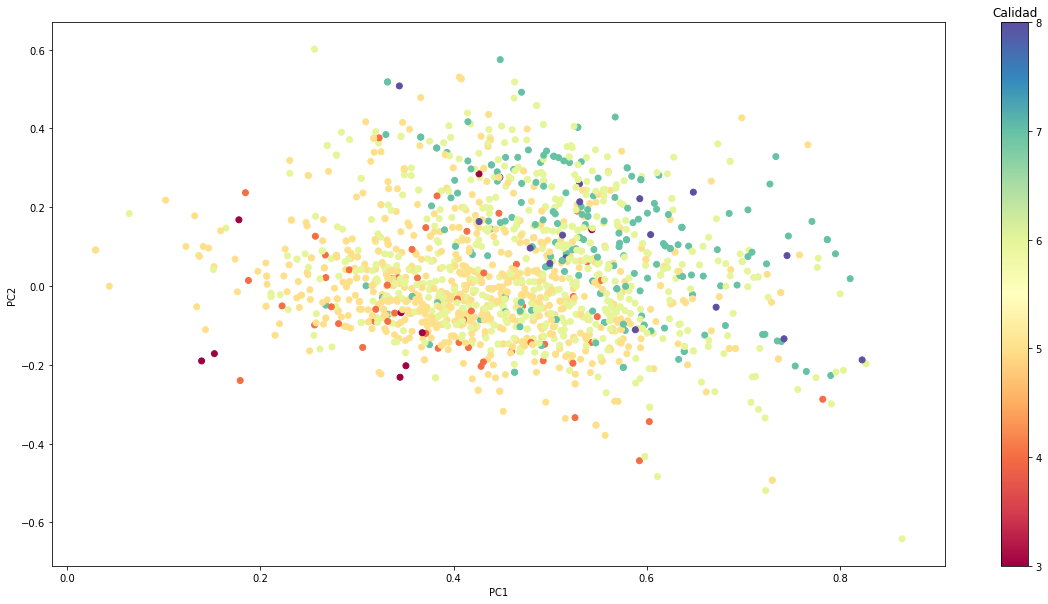

In [98]:

# Sacado de https://stackoverflow.com/questions/48854455/how-to-plot-a-matrix-in-scatterplot-python y https://stackoverflow.com/questions/52868856/add-colorbar-as-legend-to-matplotlib-scatterplot-multiple-subplots-multiple-sc
plt.figure(figsize=(20, 10))
plt.scatter(reduced[:, 1], reduced[:, 0], c=quality, cmap='Spectral')
plt.xlabel('PC1')
plt.ylabel('PC2')

norm = plt.Normalize(quality.min(), quality.max())
sm =  ScalarMappable(norm=norm, cmap='Spectral')
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.ax.set_title("Calidad")

plt.show()

**Responde:** ¿Hay algún patrón claro?¿Como podrías estimar la calidad de un vino que no se encontraba en la base de datos?

In [ ]:
# A partir de las nuevas dimensiones reducidas (PC1 y PC2), se observa que aquellos vinos que tengan la dimensión PC1 baja son de menor calidad, mientras que los que la tienen alta también tienen poseen una alta calidad.

# A partir de un vino que no esté en la base de datos, se podrían calcular estas dimensiones reducidas, y a partir del valor de PC1 se puede obtener una estimación de su calidad.